In [35]:
import os
import os.path
import sys
import h5py
import numpy as np
import scipy.io as scio
from keras.models import Model, Sequential
from keras.layers import *
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.models import load_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from tqdm import tqdm

# AES Sbox/Inverse Sbox tables

In [36]:
#AES SBox lookup table 
AES_Sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
])

#AES Inverse SBox lookup table
Inv_SBox = np.array([
    0x52, 0x09, 0x6a, 0xd5, 0x30, 0x36, 0xa5, 0x38, 0xbf, 0x40, 0xa3,
    0x9e, 0x81, 0xf3, 0xd7, 0xfb , 0x7c, 0xe3, 0x39, 0x82, 0x9b, 0x2f,
    0xff, 0x87, 0x34, 0x8e, 0x43, 0x44, 0xc4, 0xde, 0xe9, 0xcb , 0x54,
    0x7b, 0x94, 0x32, 0xa6, 0xc2, 0x23, 0x3d, 0xee, 0x4c, 0x95, 0x0b,
    0x42, 0xfa, 0xc3, 0x4e , 0x08, 0x2e, 0xa1, 0x66, 0x28, 0xd9, 0x24,
    0xb2, 0x76, 0x5b, 0xa2, 0x49, 0x6d, 0x8b, 0xd1, 0x25 , 0x72, 0xf8,
    0xf6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xd4, 0xa4, 0x5c, 0xcc, 0x5d,
    0x65, 0xb6, 0x92 , 0x6c, 0x70, 0x48, 0x50, 0xfd, 0xed, 0xb9, 0xda,
    0x5e, 0x15, 0x46, 0x57, 0xa7, 0x8d, 0x9d, 0x84 , 0x90, 0xd8, 0xab,
    0x00, 0x8c, 0xbc, 0xd3, 0x0a, 0xf7, 0xe4, 0x58, 0x05, 0xb8, 0xb3,
    0x45, 0x06 , 0xd0, 0x2c, 0x1e, 0x8f, 0xca, 0x3f, 0x0f, 0x02, 0xc1,
    0xaf, 0xbd, 0x03, 0x01, 0x13, 0x8a, 0x6b , 0x3a, 0x91, 0x11, 0x41,
    0x4f, 0x67, 0xdc, 0xea, 0x97, 0xf2, 0xcf, 0xce, 0xf0, 0xb4, 0xe6,
    0x73 , 0x96, 0xac, 0x74, 0x22, 0xe7, 0xad, 0x35, 0x85, 0xe2, 0xf9,
    0x37, 0xe8, 0x1c, 0x75, 0xdf, 0x6e , 0x47, 0xf1, 0x1a, 0x71, 0x1d,
    0x29, 0xc5, 0x89, 0x6f, 0xb7, 0x62, 0x0e, 0xaa, 0x18, 0xbe, 0x1b ,
    0xfc, 0x56, 0x3e, 0x4b, 0xc6, 0xd2, 0x79, 0x20, 0x9a, 0xdb, 0xc0,
    0xfe, 0x78, 0xcd, 0x5a, 0xf4 , 0x1f, 0xdd, 0xa8, 0x33, 0x88, 0x07,
    0xc7, 0x31, 0xb1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xec, 0x5f , 0x60,
    0x51, 0x7f, 0xa9, 0x19, 0xb5, 0x4a, 0x0d, 0x2d, 0xe5, 0x7a, 0x9f,
    0x93, 0xc9, 0x9c, 0xef , 0xa0, 0xe0, 0x3b, 0x4d, 0xae, 0x2a, 0xf5,
    0xb0, 0xc8, 0xeb, 0xbb, 0x3c, 0x83, 0x53, 0x99, 0x61 , 0x17, 0x2b,
    0x04, 0x7e, 0xba, 0x77, 0xd6, 0x26, 0xe1, 0x69, 0x14, 0x63, 0x55,
    0x21, 0x0c, 0x7d
])

In [37]:
def check_file_exists(file_path):
    file_path = os.path.normpath(file_path)
    if os.path.exists(file_path) == False:
        print("Error: provided file path '%s' does not exist!" % file_path)
        sys.exit(-1)
    return

In [38]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

# CNN - 110

In [39]:
### CNN Best model 
def cnn_best(classes=256):  
	# 70-100 epoch ,128 batch_size, 110 points
    model = Sequential()
    #model.add(GaussianNoise(0.04, input_shape=(110,1)))
    model.add(Conv1D(input_shape=(110, 1),filters=4, kernel_size=3, activation='relu', padding='same'))	
    model.add(AveragePooling1D(pool_size=2,strides=1))
    
    model.add(Conv1D(filters=8, kernel_size=3, activation='relu', padding='same'))	
    model.add(AveragePooling1D(pool_size=2,strides=1)) 

    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'))	
    model.add(AveragePooling1D(pool_size=2,strides=1))
    
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))	
    model.add(AveragePooling1D(pool_size=2,strides=1)) 
	
    model.add(Flatten())
	
    #model.add(Dropout(0.2))
	
    model.add(Dense(units = 200, activation = 'relu'))
    model.add(Dense(units = 200, activation = 'relu'))
	
    model.add(Dense(units = classes, activation = 'softmax',name='predictions'))
    optimizer = RMSprop(lr=0.00005) #0.0001
	
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	
    return model

# Train model

In [40]:
def train_model(X_profiling, Y_profiling, model, save_file_name, epochs, batch_size, model_type):
    check_file_exists(os.path.dirname(save_file_name))
    
    # Save model every epoch
    save_model = ModelCheckpoint(save_file_name)
    callbacks = [save_model]
    
    # Get the input layer shape
    input_layer_shape = model.get_layer(index=0).input_shape
    
    # Sanity check
    if input_layer_shape[1] != len(X_profiling[0]):
        print("Error: model input shape %d instead of %d is not expected ..." % (
            input_layer_shape[1], len(X_profiling[0])))
        sys.exit(-1)
    elif len(input_layer_shape) == 3:
        # This is a CNN: expand the dimensions
        Reshaped_X_profiling = X_profiling.reshape((X_profiling.shape[0], X_profiling.shape[1], 1))
        Reshaped_Y_profiling = to_categorical(Y_profiling, num_classes=256)
        if model_type ==6:
            Reshaped_Y_profiling = Y_profiling.reshape((Y_profiling.shape[0], Y_profiling.shape[1], 1))
    else:
        print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
        sys.exit(-1)

    history = model.fit(x=Reshaped_X_profiling, y=Reshaped_Y_profiling, batch_size=batch_size, verbose=1, epochs=epochs, callbacks=callbacks, validation_split=0.1)
    return history

# Main - No noise

In [41]:
MODEL_TYPE = 2 #CNN
INTEREST_BYTE = 0
MODEL_FOLDER = "cnn_110_maf_n3/"
TRAINING_MODEL = MODEL_FOLDER + 'cnn_model-{epoch:01d}.h5'
USER = os.getenv("USER")
traces = np.load('data/nor_traces_maxmin.npy')
#traces = traces[:,[i for i in range(204,314)]]

In [8]:
#traces_fixed = traces.copy()
#noise_traces_flattened_fixed = traces_fixed.flatten()

noise_data = np.load(f"/Users/{USER}/Documents/MASTER-THESIS/datasets/last_round_aes/experiment_axel/test_1/traces.npy")
index_1 = int(512400 / 400)
index_2 = int(1824800 / 400)
noise_data[index_1] = noise_data[index_1 -20]
noise_data[index_2] = noise_data[index_2 -20]
noise_data = noise_data[:,[i for i in range(204,314)]]
noise_data_flatten = noise_data.flatten()
scale = 75
translation = 0
noise_data = (noise_data - translation) * scale

nr = int(len(traces) / len(noise_data))
noise_data_2 = np.tile(noise_data, (nr,1))

In [40]:
# Add noise traces to traces
noise_traces = traces.copy()

for i in range(len(traces)):
    noise_traces[i] = noise_data_2[i] + noise_traces[i]

In [49]:
# Add modelled noise to training traces
# Rayleigh

for i in range(len(traces)):
    #noise = np.random.rayleigh(0.0138*2,110)
    noise = np.random.normal(0,0.05,110)
    noise_traces[i] = noise_traces[i] + noise

In [60]:
# MAF filter training data

def moving_avg_trace(trace, n):
    #trace = trace.copy()
    cumsum = np.cumsum(np.insert(trace, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

#filtered_traces = traces.copy()
filtered_traces = np.empty_like(traces)

for i in tqdm(range(len(traces))):
    #np.append(filtered_traces, moving_avg_trace(traces[i], 3))
    filtered_traces[i] = np.pad(moving_avg_trace(traces[i], 3), (0,2),'constant')
filtered_traces = filtered_traces[:,[i for i in range(203,313)]]

100%|█████████████████████████████████████████████| 200000/200000 [00:16<00:00, 11959.76it/s]


In [51]:
print(filtered_traces.size)

22000000


# Plot

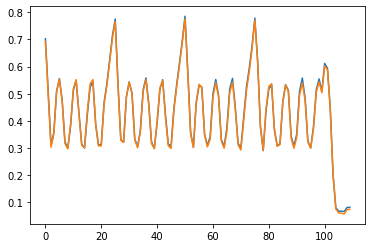

In [61]:
%matplotlib inline

gauss_noise = np.random.normal(0,0.02,110)
rayleigh_noise = np.random.rayleigh(0.02, 110)

#plt.plot(traces[0])
plt.plot(filtered_traces[0])
plt.plot(filtered_traces[2])
#plt.plot(noise_traces[2])
#plt.plot(noise_data_2[0])
#plt.plot(gauss_noise)
#plt.plot(noise)
#plt.axvline(x=204)
#plt.axvline(x=314)
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.grid(True)
plt.show()

In [ ]:
plt.psd(filtered_traces[0])
plt.show()

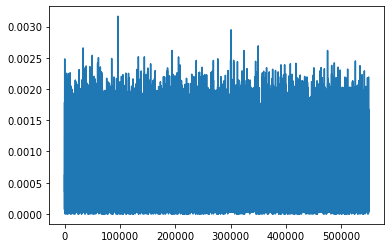

In [52]:
plt.plot(noise_data_flatten)
plt.show()

In [62]:
ct = np.load('data/ct.npy')
key=np.load('data/lastroundkey.npy')
key= key.astype(int)
#print(key[:,interest_byte].shape)
lastround_sboxout= np.bitwise_xor(ct[:,INTEREST_BYTE],key[:,INTEREST_BYTE])
#lastround_input= Inv_SBox[lastround_sboxout]  
labels=lastround_sboxout

# CNN model
model = cnn_best()
print(model.summary())

EPOCHS = 100
BATCH_SIZE = 256

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 110, 4)            16        
_________________________________________________________________
average_pooling1d (AveragePo (None, 109, 4)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 109, 8)            104       
_________________________________________________________________
average_pooling1d_1 (Average (None, 108, 8)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 108, 16)           400       
_________________________________________________________________
average_pooling1d_2 (Average (None, 107, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 107, 32)           1

2021-11-05 00:23:03.721444: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Train

In [63]:
history_log = train_model(filtered_traces, labels, model, TRAINING_MODEL, EPOCHS, BATCH_SIZE, MODEL_TYPE)
np.save(MODEL_FOLDER + "history_log.npy", history_log.history)

2021-11-05 00:23:15.280254: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
704/704 [==============================] - 35s 48ms/step - loss: 5.5452 - accuracy: 0.0040 - val_loss: 5.5451 - val_accuracy: 0.0042
Epoch 2/100
704/704 [==============================] - 33s 47ms/step - loss: 5.5451 - accuracy: 0.0045 - val_loss: 5.5451 - val_accuracy: 0.0042
Epoch 3/100
704/704 [==============================] - 33s 47ms/step - loss: 5.5450 - accuracy: 0.0043 - val_loss: 5.5451 - val_accuracy: 0.0042
Epoch 4/100
704/704 [==============================] - 33s 47ms/step - loss: 5.5449 - accuracy: 0.0041 - val_loss: 5.5450 - val_accuracy: 0.0042
Epoch 5/100
704/704 [==============================] - 33s 47ms/step - loss: 5.5449 - accuracy: 0.0041 - val_loss: 5.5451 - val_accuracy: 0.0042
Epoch 6/100
704/704 [==============================] - 33s 47ms/step - loss: 5.5449 - accuracy: 0.0042 - val_loss: 5.5451 - val_accuracy: 0.0042
Epoch 7/100
704/704 [==============================] - 33s 47ms/step - loss: 5.5447 - accuracy: 0.0044 - val_loss: 5.5451 - val_ac

# Performance plots

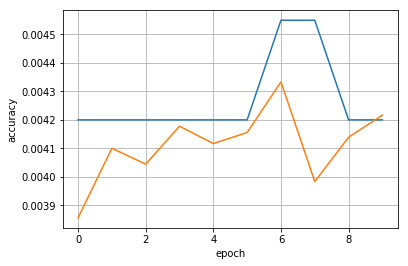

In [21]:
plt.plot(history_log.history['val_acc'])
plt.plot(history_log.history['acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

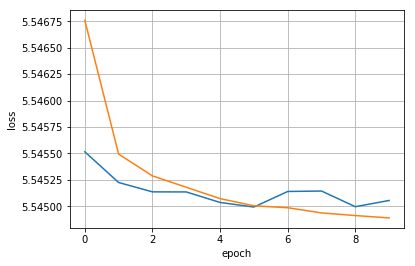

In [22]:
plt.plot(history_log.history['val_loss'])
plt.plot(history_log.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.show()